In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle

In [60]:
metrics = {
    "ID":  "ID Accuracy",
    "OOD": "OOD Accuracy",
    "NMI": "NMI \n (clustering)",
    "Precision":  "Precision@10 \n (reranking)",
}
metric_keys = list(metrics.keys())

In [61]:
def melt(df):
    error_metrics = [m + "_err" for m in metric_keys]

    # Melt the score columns
    df_scores = df[["Method", "Architecture"] + metric_keys].melt(
        id_vars=["Method", "Architecture"],
        var_name="Metric",
        value_name="Score"
    )

    # Melt the error columns
    df_errors = df[["Method", "Architecture"] + error_metrics].melt(
        id_vars=["Method", "Architecture"],
        var_name="Metric",
        value_name="Error"
    )

    # Fix the 'Metric' column in errors to match scores (remove '_err' suffix)
    df_errors["Metric"] = df_errors["Metric"].str.replace("_err", "", regex=False)

    # Merge scores and errors
    return pd.merge(df_scores, df_errors, on=["Method", "Architecture", "Metric"])

In [62]:
df = pd.read_csv("amazon.csv")
df_melted = melt(df)

In [63]:
# Shared variables
architecture_order = ["E5", "CSR"]
method_order = df.sort_values("Architecture", key=lambda x: x.map({k: i for i, k in enumerate(architecture_order)}))["Method"].tolist()
method_arch = dict(zip(df["Method"], df["Architecture"]))
e5_methods = df[df["Architecture"] == "E5"]["Method"].tolist()
sfr_methods = df[df["Architecture"] == "SFR"]["Method"].tolist()

palette = sns.color_palette(["#6a4c93", "#CB9DF0", "#80b1d3", "#4267ac", "#52a675", "#c5ca30", "#ffca3a", "#ff924c", "#ff595e", "#A02334"])

custom_palette = dict(zip(e5_methods + sfr_methods, palette))

In [64]:
def sort_method_order(df):
    # Assume df is your DataFrame
    df['Method'] = pd.Categorical(df['Method'], categories=method_order, ordered=True)
    df['Metric'] = pd.Categorical(df['Metric'], categories=metric_keys, ordered=True)

    # Now sort by both
    return df.sort_values(by=['Method', 'Metric']).reset_index(drop=True)

# reorder the rows according to metrics and then by method_order
df_melted = sort_method_order(df_melted)

/tmp/ipykernel_87847/1020177432.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  print(ax.xaxis.set_ticklabels(metrics.values(), fontsize=14))


[Text(0, 0, 'ID Accuracy'), Text(1, 0, 'OOD Accuracy'), Text(2, 0, 'NMI \n (clustering)'), Text(3, 0, 'Precision@10 \n (reranking)')]


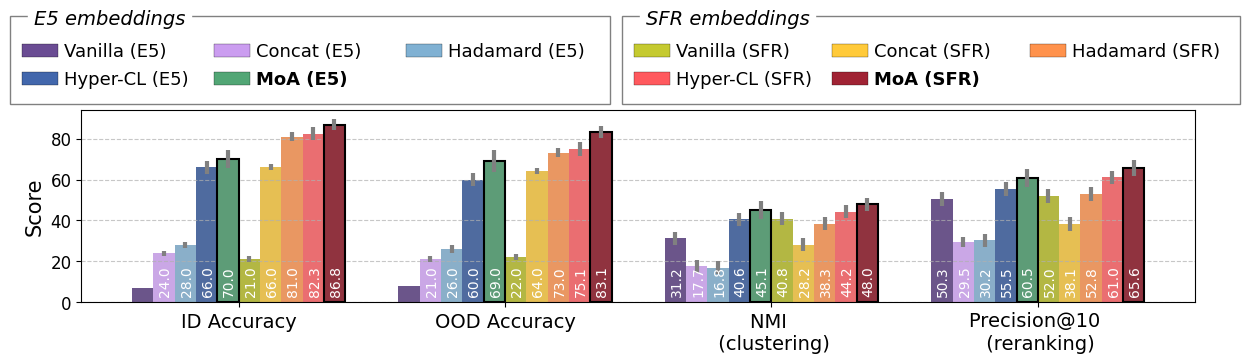

In [103]:
# Create plot (only 1 used)
fig, ax = plt.subplots(figsize=(12, 3.5))

# Barplot
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Method",
            hue_order=method_order, palette=custom_palette, ax=ax, zorder=1)
ax.set_xlabel("")
ax.set_ylabel("Score", fontsize=15)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(labelsize=12)
ax.legend_.remove()

rows = [row for _, row in df_melted.iterrows()]
row_idx = 0
for container in list(ax.containers):
    for bar in container:
        row = rows[row_idx]
        try:
            height = bar.get_height()
            yerr = row['Error']
            x = bar.get_x() + bar.get_width() / 2
            if height > 10:
                ax.text(x + 0.005, 3, f"{height:.1f}", ha='center', va='bottom', fontsize=10, color='white', rotation=90)
                ax.errorbar(x, height, yerr=yerr, color='gray', elinewidth=3)
            if 'MoA' in row['Method']:
                bar.set_zorder(2)
                bar.set_edgecolor("black")
                bar.set_linewidth(1.5)
        except:
            print("Error in error bar calculation")
        row_idx += 1

print(ax.xaxis.set_ticklabels(metrics.values(), fontsize=14))

# Custom legend
group_y_top = 0.94
row_height = 0.08
icon_size = 0.03
text_offset_x = 0.035

# E5 Group
x_start_left = 0.01
row_items = 3
x_spacing = 0.16
fig.text(x_start_left + 0.01, group_y_top + 0.03, "E5 embeddings", fontsize=14, style='italic', va='bottom', backgroundcolor='white')

for idx, method in enumerate(e5_methods):
    row = idx // row_items
    col = idx % row_items
    x = x_start_left + col * x_spacing
    y = group_y_top - row * row_height - 0.05
    fig.patches.append(Rectangle((x, y), icon_size, 1.2 * icon_size,
                                 transform=fig.transFigure, facecolor=custom_palette[method], edgecolor='black', linewidth=0.2))
    if 'MoA' in method:
        fig.text(x + text_offset_x, y - 0.012, method, fontsize=13, va='bottom', fontweight='bold', zorder=2)
    else:
        fig.text(x + text_offset_x, y - 0.012, method, fontsize=13, va='bottom')
        
E5_width = (min(row_items, len(e5_methods)) * x_spacing)
E5_height = (1 + (len(e5_methods)-1)//row_items) * row_height
fig.patches.append(Rectangle((x_start_left - 0.01, group_y_top - E5_height- 0.025),
                             E5_width + 0.02, E5_height + 0.09,
                             transform=fig.transFigure, facecolor='none', edgecolor='gray', linewidth=1))

# SFR Group
x_start_right = 0.52
x_spacing = 0.165
fig.text(x_start_right + 0.01, group_y_top + 0.03, "SFR embeddings", fontsize=14, style='italic', va='bottom', backgroundcolor='white')

for idx, method in enumerate(sfr_methods):
    row = idx // row_items
    col = idx % row_items
    x = x_start_right + col * x_spacing
    y = group_y_top - row * row_height - 0.05
    fig.patches.append(Rectangle((x, y), icon_size, 1.2 * icon_size,
                                 transform=fig.transFigure, facecolor=custom_palette[method], edgecolor='black', linewidth=0.2))
    if 'MoA' in method:
        fig.text(x + text_offset_x, y - 0.012, method, fontsize=13, va='bottom', fontweight='bold', zorder=2)
    else:
        fig.text(x + text_offset_x, y - 0.012, method, fontsize=13, va='bottom')

SFR_width = (min(row_items, len(sfr_methods)) * x_spacing)
SFR_height = (1 + (len(sfr_methods)-1)//row_items) * row_height
fig.patches.append(Rectangle((x_start_right - 0.01, group_y_top - SFR_height - 0.025),
                             SFR_width + 0.02, SFR_height + 0.09,
                             transform=fig.transFigure, facecolor='none', edgecolor='gray', linewidth=1))

plt.tight_layout(rect=[0, 0, 1, 0.78])  # Reserve space at top
fig.savefig("amazon_plot.pdf", format="pdf", bbox_inches="tight")

plt.show()